In [1]:
import os
import sys
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import corner
from sklearn.preprocessing import QuantileTransformer, StandardScaler

In [2]:
jax.devices()

[CudaDevice(id=0)]

In [3]:
sys.path.append("/n/home12/sratzenboeck/code/AstroSimformer/train_interface/")
sys.path.append("/n/home12/sratzenboeck/code/AstroSimformer/dev_jax_flow/core/")
sys.path.append("/n/home12/sratzenboeck/code/AstroSimformer/")

In [4]:
from dev_jax_flow.core.build_transformer_model import build_transformer_model
from dev_jax_flow.core.trainer_encoder import TrainFlowModel
from train_interface.config_class import (TrainingConfig, SimformerConfig, TransformerConfig,
                                          DiffusionConfig, set_config_values)
from dev_jax_flow.core.euler_sampler import pure_batched_sampler
from dev_jax_flow.core.config_class import load_config

# Load data

In [5]:
fname_basel = '/n/home12/sratzenboeck/data_local/mock/cluster_field_1kpc_fundamentals_Bayestar2019_SED_BaSeL_June2025.parquet'

df_sim = pd.read_parquet(fname_basel)
df_sim['dist'] = 1000./df_sim['parallax']

N = df_sim.shape[0]

In [6]:
# plt.hist(df_sim.logg, bins=100);

# Define features

In [7]:
feats_theta = [
    'logg', 'logT', 'logAge', 'Z_metal', 'Av', 'dist'
]

lamost_cols = [col for col in df_sim.columns if 'lamost_' in col]
apogee_cols = [col for col in df_sim.columns if 'apogee_' in col]
boss_cols   = [col for col in df_sim.columns if 'boss_' in col]
xp_cols     = [col for col in df_sim.columns if 'xp_' in col]

In [8]:
# plt.hist(df_sim['dist'], bins=100, log=True);

# Randomly remove values

In [9]:
set_nans = False

In [10]:
# Randomly drop Gaia, Spitzer, 2MASS, or Wise photometry
gaia_cols = ['gaia_bp_phot', 'gaia_rp_phot', 'gaia_g_phot', 'parallax_obs']
tmass_cols = ['2mass_h', '2mass_j', '2mass_k']
spitzer_cols = ['irac_1', 'irac_2', 'irac_3', 'irac_4']
wise_cols = ['wise_1', 'wise_2', 'wise_3', 'wise_4']
phot_cols = [gaia_cols, tmass_cols, spitzer_cols, wise_cols]
# Random drop rate
drop_rate_gaia = 0.1
drop_rate_tmass = 0.2
drop_rate_spitzer = 0.9
drop_rate_wise = 0.5
drs = [drop_rate_gaia, drop_rate_tmass, drop_rate_spitzer, drop_rate_wise]

if set_nans:
    # Set values to nan
    for dr, cols in zip(drs, phot_cols):
        rows_to_nan_sim = np.random.choice(N, size=int(N * dr), replace=False)
        rows_to_nan_real = np.random.choice(N, size=int(N * dr), replace=False)
        # Set selected rows to NaN
        df_sim.loc[rows_to_nan_sim, cols] = np.nan
else:
    df_sim = df_sim.dropna().reset_index(drop=True)

In [11]:
# --- Define modalities and dimensions ---
# modalities = ['xp', 'lamost', 'boss', 'apogee' , 'gaia_phot', '2mass_phot', 'wise_phot', 'spitzer_phot']
# Exclude some modalities
modalities = ['xp', 'gaia_phot', '2mass_phot', 'wise_phot', 'spitzer_phot']
input_cols = {
    'xp': xp_cols,
    'lamost': lamost_cols,
    'boss': boss_cols,
    'apogee': apogee_cols,
    'gaia_phot': gaia_cols,
    '2mass_phot': tmass_cols,
    'wise_phot': wise_cols,
    'spitzer_phot': spitzer_cols,
}
input_dims = {
    'xp': len(xp_cols),
    'lamost': len(lamost_cols),
    'boss': len(boss_cols),
    'apogee': len(apogee_cols),
    'gaia_phot': len(gaia_cols),
    '2mass_phot': len(tmass_cols),
    'wise_phot': len(wise_cols),
    'spitzer_phot': len(spitzer_cols),
}
latent_dims = {
    'xp': 128,
    'lamost': 128,
    'boss': 128,
    'apogee': 128,
    'gaia_phot': 8,
    '2mass_phot': 8,
    'wise_phot': 8,
    'spitzer_phot': 8
}
trafo_dict = load_config('/n/home12/sratzenboeck/code/AstroSimformer/dev_jax_flow/simformer_config.json')
# --- Create toy data ---
key = jax.random.PRNGKey(0)
BATCH_SIZE = 2**10

# Store training data
sim_data = {mod: df_sim[input_cols[mod]].values for mod in modalities}
sim_data['theta'] = df_sim[feats_theta].values

# Normalize spectra

In [12]:
log_specs_first = False

normalization_info = {}
sim_data_normed = {}
real_data_normed = {}
pair_data_normed = {}
test_data_normed = {}
spec_cols = ['xp', 'lamost', 'boss', 'apogee']

if log_specs_first and (len(spec_cols)==0):
    for sp_mod in ['xp', 'lamost', 'boss', 'apogee']:
        sim_data[mod] = np.log10(sim_data[mod]+1e-22)
    
for mod in sim_data.keys():
    if mod in spec_cols:
        # Log normalization for spectra and normalize over entire spectra not per pixel
        log_mean_val = np.nanmean(np.log10(sim_data[mod]))
        log_std_val = np.nanstd(np.log10(sim_data[mod]))
        # Normalize values
        sim_mod_normed = (np.log10(sim_data[mod]) - log_mean_val) / log_std_val
        normalization_info[mod] = {'mean': log_mean_val, 'std': log_std_val, 'log': True}
        # Set
        if mod == 'apogee':
            print('downsampling apogee')
            sim_data_normed[mod] = sim_mod_normed[:, ::50]
        else:
            sim_data_normed[mod] = sim_mod_normed
    else:
        # mean_val = np.nanmean(sim_data[mod], axis=0)
        # std_val = np.nanstd(sim_data[mod], axis=0)
        # qt = QuantileTransformer(output_distribution='normal')
        qt = StandardScaler()
        dat_normalized = qt.fit_transform(sim_data[mod])
        normalization_info[mod] = {'qt': qt}
        # Normalize values
        # sim_mod_normed = dat_normalized
        # Set
        sim_data_normed[mod] = dat_normalized

In [13]:
# for i in range(5):
#     _, bins, _ = plt.hist(sim_data_normed['theta'][:,i], bins=100, label='simulated', alpha=0.5, density=True, log=True)
#     plt.xlabel(feats_theta[i])
#     plt.show()

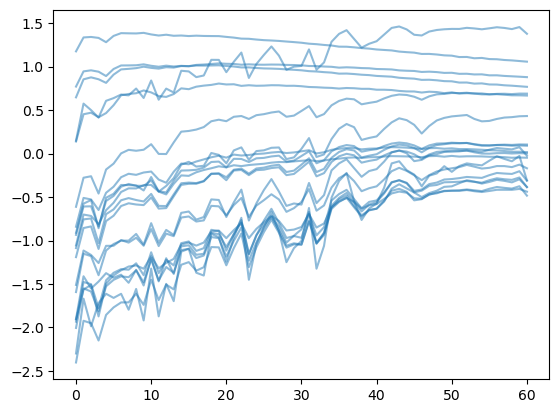

In [14]:
for i in range(20):
    plt.plot(sim_data_normed['xp'][i], label='simulated', c='C0', alpha=0.5)
    # plt.show()
# plt.legend()
plt.show()

# Concert into single JAX array

In [15]:
d_list = []
condition_groups = []
encoder_mask = []
print('Modalities inserted into training data:')
for i, (mod, mod_arr) in enumerate(sim_data_normed.items()):
    d_list.append(mod_arr)
    dims = mod_arr.shape[1]
    print(f'{mod} is {dims}D') 
    condition_groups.append(jnp.ones(dims, dtype=int)*i)
    em = np.zeros(dims, dtype=bool) if mod=='theta' else np.ones(dims, dtype=bool)
    encoder_mask.append(em)

data = jnp.asarray(jnp.concatenate(d_list, axis=1))[..., jnp.newaxis]
condition_groups = jnp.concatenate(condition_groups, axis=0)
encoder_mask = np.concatenate(encoder_mask, axis=0)

Modalities inserted into training data:
xp is 61D
gaia_phot is 4D
2mass_phot is 3D
wise_phot is 4D
spitzer_phot is 4D
theta is 6D


In [16]:
condition_groups.shape, data.shape, encoder_mask.shape, encoder_mask.sum()

((82,), (46327, 82, 1), (82,), np.int64(76))

In [17]:
encoder_mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False])

# Set up training

In [18]:
trafo_dict

{'dim_value': 20,
 'dim_id': 20,
 'dim_condition': 10,
 'num_heads': 4,
 'num_layers': 3,
 'attn_size': 32,
 'widening_factor': 8,
 'epochs': 1000,
 'time_steps': 512}

In [19]:
# This creates the SDE for noise in diffusion model
# data_clean = data.copy()
# impute NaNs with 0 -> this is done for because "Independent" cannot handle NaNs
# but these values will be masked during training so it will not affect the learning
# data_clean = jnp.nan_to_num(data_clean, 0.0)

# === Model parameters ===
nodes_max = sum(latent_dims.values()) + len(feats_theta) #- (len(average_groups[0])-1) * latent_dims[list(average_groups[0])[0]]
model_init, model_fn = build_transformer_model(
    nodes_max=nodes_max,
    dim_value=trafo_dict['dim_value'],
    dim_id=trafo_dict['dim_id'],
    dim_condition=trafo_dict['dim_condition'],
    num_heads=trafo_dict['num_heads'],
    num_layers=trafo_dict['num_layers'],
    attn_size=trafo_dict['attn_size'],
    widening_factor=trafo_dict['widening_factor'],
    embed_time_dim=128
)

# Use a small batch to initialize the model
x0 = jnp.zeros((BATCH_SIZE, nodes_max, 1))
t = jnp.ones((BATCH_SIZE, 1))
node_ids = jnp.arange(nodes_max)
cond_mask = jnp.zeros_like(node_ids).astype(jnp.float32)
edge_mask = jnp.ones((BATCH_SIZE, nodes_max, nodes_max), dtype=bool)
params = model_init(key, t, x0, node_ids, cond_mask, edge_mask)

2025-06-19 20:44:00.735165: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


In [20]:
# os.mkdir("./checkpoints")

In [21]:
3 * data.shape[0] // BATCH_SIZE, BATCH_SIZE

(135, 1024)

In [22]:
%%time
train_model = TrainFlowModel(
    key=key,
    data=data,                        # shape (N, T, 1)
    model_fn=model_fn,                # Haiku-transformed apply fn
    params=params,
    nodes_max=data.shape[1],
    condition_groups=None,
    encode_mask=encoder_mask,
    batch_size=BATCH_SIZE,
    lr=1e-3,
    inner_train_loop_size=250,
    early_stopping_patience=30,
    model_check_point_dir=None, #"./checkpoints"  # optional
    encoder_hidden_dim=128
)

in_dim  76
CPU times: user 1.1 s, sys: 54.4 ms, total: 1.15 s
Wall time: 1.35 s


In [23]:
%%time
best_params = train_model.fit(epochs=100)

batch_xs.shape  (1024, 82, 1)
Current alpha=Traced<~float32[]>with<DynamicJaxprTrace>


2025-06-19 20:44:05.448583: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-06-19 20:44:05.448627: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-06-19 20:44:05.448832: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


Epoch 1: loss = 1.591739
Epoch 2: loss = 1.179365
Epoch 3: loss = 1.099684
Epoch 4: loss = 1.022327
Epoch 5: loss = 0.942043
Epoch 6: loss = 0.863349
Epoch 7: loss = 0.836923
Epoch 8: loss = 0.817171
Epoch 9: loss = 0.803168
Epoch 10: loss = 0.791970
Epoch 11: loss = 0.773573
Epoch 12: loss = 0.772417
Epoch 13: loss = 0.756424
Epoch 14: loss = 0.748690
Epoch 15: loss = 0.729303
Epoch 16: loss = 0.742110
Epoch 17: loss = 0.740319
Epoch 18: loss = 0.715584
Epoch 19: loss = 0.713491
Epoch 20: loss = 0.725522
Epoch 21: loss = 0.714445
Epoch 22: loss = 0.684291
Epoch 23: loss = 0.675968
Epoch 24: loss = 0.651809
Epoch 25: loss = 0.632740
Epoch 26: loss = 0.615141
Epoch 27: loss = 0.602555
Epoch 28: loss = 0.608855
Epoch 29: loss = 0.585954
Epoch 30: loss = 0.573385
Epoch 31: loss = 0.566431
Epoch 32: loss = 0.543197
Epoch 33: loss = 0.564602
Epoch 34: loss = 0.544738
Epoch 35: loss = 0.541411
Epoch 36: loss = 0.522496
Epoch 37: loss = 0.521392
Epoch 38: loss = 0.507961
Epoch 39: loss = 0.51

In [24]:
cond_arr = []
for mod, mod_arr in sim_data_normed.items():
    if mod == 'theta':
        # For theta, we use the mean and std of the training data
        cond_arr.append(jnp.zeros(mod_arr.shape[1], dtype=int))
    else:
        cond_arr.append(jnp.ones(mod_arr.shape[1], dtype=int))
        
condition_mask = jnp.concatenate(cond_arr)

In [25]:
condition_mask

Array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], dtype=int32)

In [26]:
shape = (2**10,)
# dim2keep = 1
all_node_ids = jnp.arange(data.shape[1])
condition_value = data[0].flatten()
edge_mask = jnp.ones((data.shape[1], data.shape[1]), dtype=bool)  # shape (B, T, T)

# Prepare test point

2025-06-19 20:50:24.161547: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


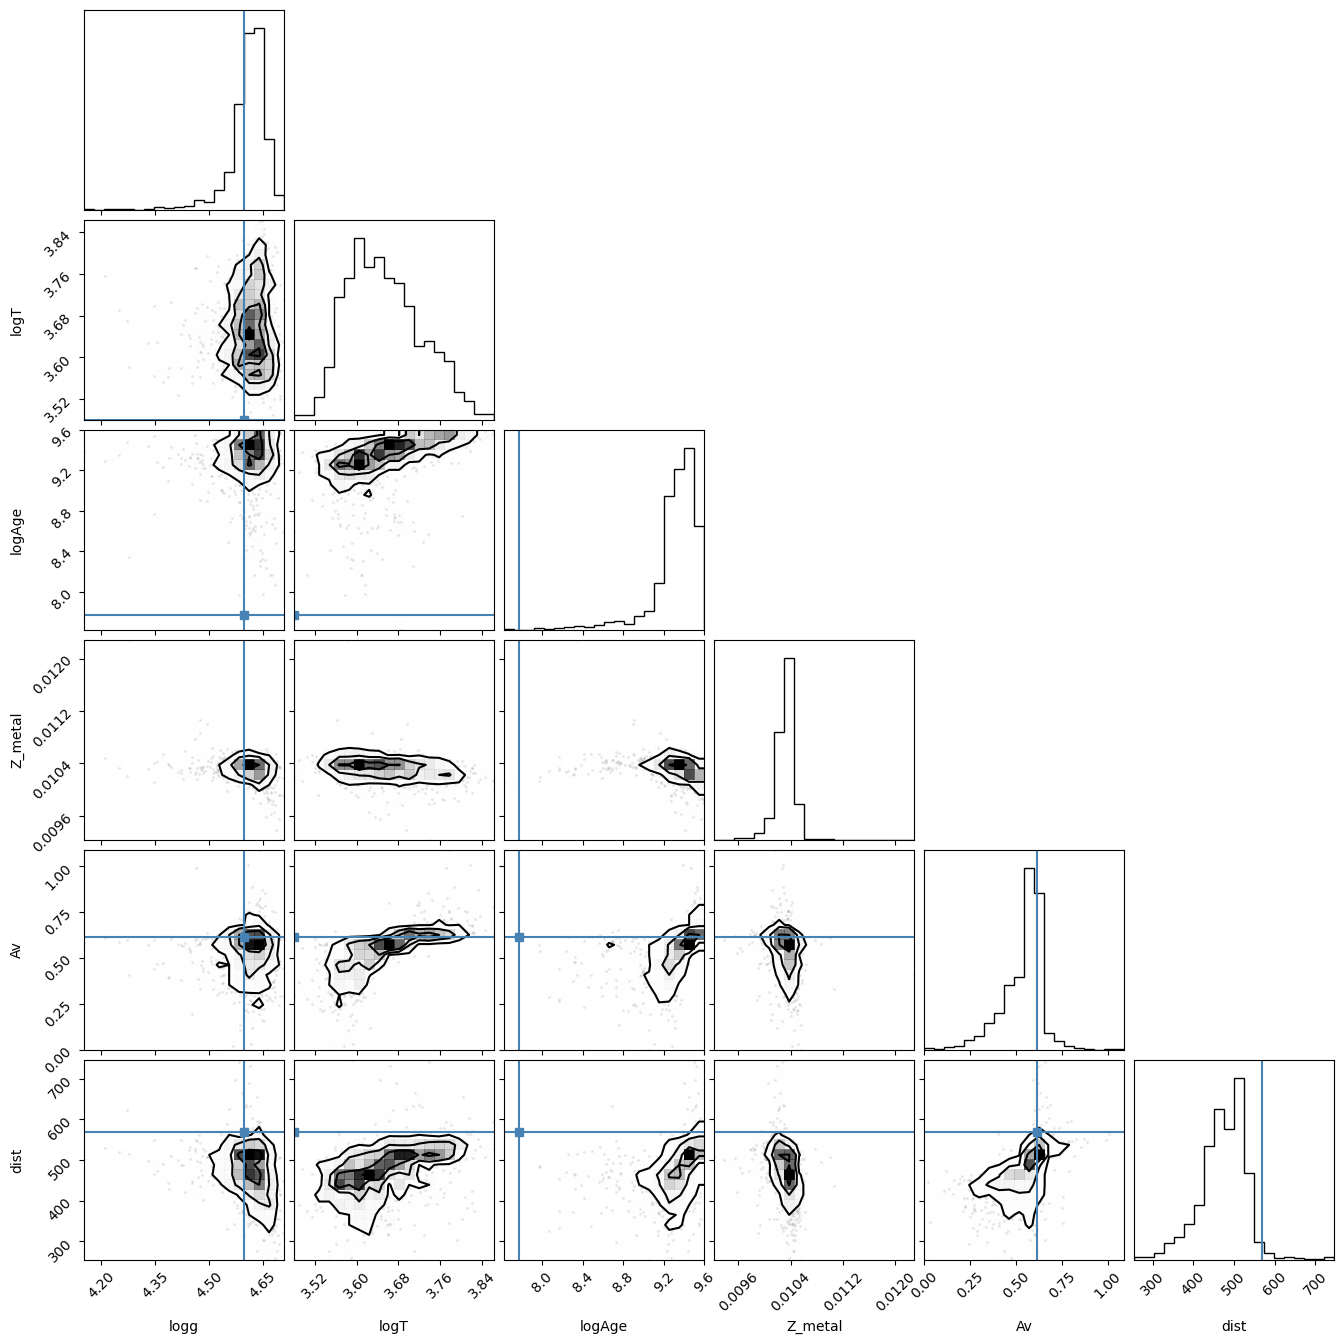

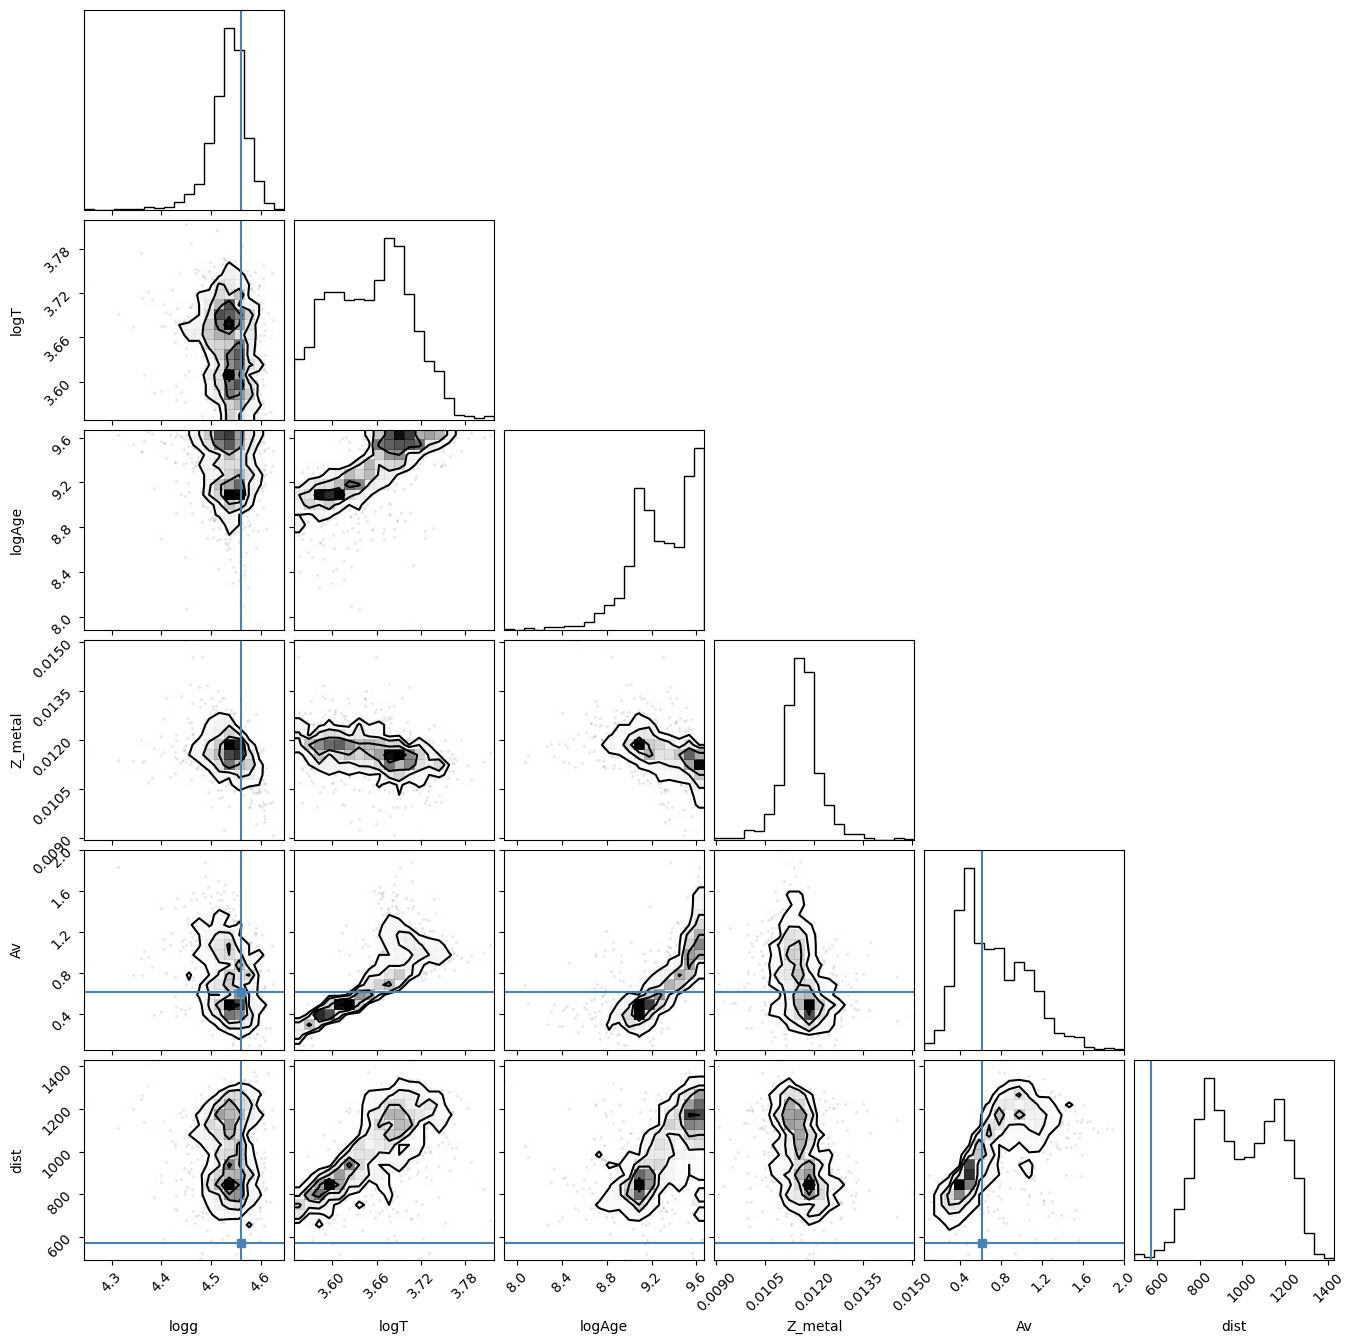

In [ ]:
for i in range(10):
    idx = np.where(sim_data['theta'][:,2]<8)[0][i]
    condition_value = data[idx].flatten()
    theta_true = sim_data['theta'][idx]
    # Draw posterior samples
    post_samples = pure_batched_sampler(
        train_model.model_fn,                         # static
        train_model.opt_params,                       # static
        key,
        shape,                               # shape tuple, not an integer
        condition_mask,                               # (B, T)
        condition_value,                              # (B, T)
        # jnp.tile(jnp.arange(dim)[None], (num_samples, 1)),  # (B, T)
        all_node_ids,
        edge_mask,                                    # (B, T, T)
        128,                                           # steps (static)
        0.0,                                          # t0
        1.0,                                          # t1
    )
    post_samples_np = jax.device_get(post_samples)
    posterior = normalization_info['theta']['qt'].inverse_transform(post_samples_np[:,-6:])
    corner.corner(posterior, truths=theta_true, labels=feats_theta)
    plt.show()